# 0. Importing packages

In [1]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from scipy.interpolate import interp1d

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# 1. Solving for steady state

The model to be solved can be written as:
$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t N_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t N_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{B}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{B}
\\
\mathcal{H}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{H}
\\
\varphi N_t^{\nu} \frac{1}{\theta}\left(C_{t}^\theta H_t^{1-\theta}\right)^\sigma\left(\frac{C_{t}}{H_t}\right)^{1-\theta} - w_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\quad t = 0, 1, \dots
$$

## 1.1. Household/HA block

Let's first construct our household/HA block to be used for both the steady state DAG and the transition DAG 

In [12]:
# load the HA block
hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

print(f'Inputs: {hh1.inputs}')
print(f'Macro outputs: {hh1.outputs}')
print(f'Micro outputs: {hh1.internals}')

Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'qh_lag', 'r', 'alpha', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Div', 'Tax']
Macro outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Vh_bhat', 'Vb_bhat', 'h_bhat', 'b_bhat', 'c_bhat', 'uce_bhat', 'chi', 'Psi1', 'b_bhat_grid', 'h_bhat_grid', 'k_grid', 'e_grid', 'pi_e', 'z_grid']


## 1.2. Other blocks for steady state

Now the other blocks for the model can be defined

In [13]:
@simple
def firm(N, w, Z, pi, mu, kappa):
    # N = Y / Z
    Y = Z * N
    Div = Y - w * N - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return Y, Div

@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, BBAR):
    Tax = r * BBAR
    return Tax

@simple
def wage_res(C_BHAT, H_BHAT, N, varphi, nu, theta, sigma, w):
    wage_res = varphi * N ** nu * 1 / theta * (C_BHAT**theta*H_BHAT**(1-theta))**sigma * (C_BHAT/H_BHAT)**(1-theta) - w
    return wage_res

@simple
def mkt_clearing(B_BHAT, C_BHAT, Y, BBAR, pi, mu, kappa, HBAR, H_BHAT, CHI, qh_lag, gamma):
    asset_mkt = BBAR + gamma*qh_lag*H_BHAT - B_BHAT
    goods_mkt = Y - C_BHAT - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y - CHI
    house_mkt = HBAR - H_BHAT
    return asset_mkt, goods_mkt, house_mkt

@simple 
def qhouse_lag(qh):
    qh_lag = qh(-1)
    return qh_lag

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

## 1.3. Creating the model and solving for steady state

In [14]:
blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'alpha', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'N', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi', 'BBAR', 'varphi', 'nu', 'HBAR']
Outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'w', 'qh_lag']


In [16]:
import warnings
warnings.simplefilter('always', RuntimeWarning)

calibration = {'gamma': 0.8, 'theta': 0.89, 'sigma': 2.5, 'alpha': 1.5, 'bmax': 50,
               'hmax': 10, 'kmax': 1, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 2.0, 'HBAR': 1.0}

# Calibrated parameters: beta (for goods market clearing), qh (for house market clearing), phi (for the wage schedule), w (for the Philips curve)
unknowns_ss = {'beta': 0.986, 'varphi': 0.8, 'qh': 5.0}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
ss =  hank_ss.steady_state(ss0)

c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:58: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:58: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:58: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:58: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:58: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:58: RuntimeWarnin

### 1.3.1. Printing steady state results

In [17]:
print(f"Asset market clearing (untargeted): {ss['asset_mkt']: 0.2e}")
print(f"Goods market clearing: {ss['goods_mkt']: 0.2e}")
print(f"Housing market clearing: {ss['house_mkt']: 0.2e}")
print(f"Wage schedue residual: {ss['wage_res']: 0.2e}")
print(f"SS beta: {ss['beta']}")
print(f"SS qh: {ss['qh_lag']}")
print(f"SS qh: {ss['qh']}")
print(f"SS wage: {ss['w']}")
print(f"SS r: {ss['r']}")
print(ss['varphi'])
print(ss['H_BHAT'])
print(f"qh*H/(4*Y): {ss['H_BHAT']*ss['qh']/(4*ss['Y'])}")

Asset market clearing (untargeted): -8.30e-07
Goods market clearing:  1.27e-13
Housing market clearing:  8.03e-13
Wage schedue residual: -4.24e-12
SS beta: 0.9783174132410798
SS qh: 23.57191223021281
SS qh: 23.57191223021281
SS wage: 0.8333333333333334
SS r: 0.004999999999999893
0.7425907097154639
0.9999999999991966
qh*H/(4*Y): 5.8929780575484685


### 1.3.2. Plotting the steady stage policy functions

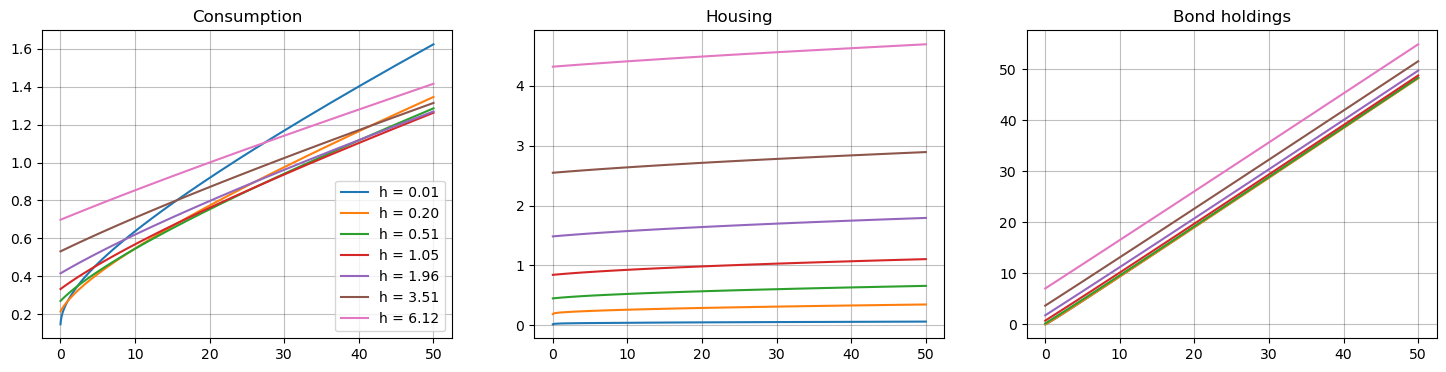

In [18]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

z_point = 0
for i_h in range(0, calibration['nH'], 10):
    ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['c_bhat'][z_point,:, i_h], label=f'h = {ss.internals["hh_housecons"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['b_bhat'][z_point,:, i_h])

ax.legend()
ax.set_title('Consumption')
ax2.set_title('Housing')
ax3.set_title('Bond holdings')

plt.show()

# 2. Transitional dynamics

## 2.1. Building the DAG for transitional dynamics

Have to do a sligth modification of the DAG for transitional dyanmics, because the `nkpc_ss` block is not valid for anything but steady state

In [19]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc, qhouse_lag]
hank = create_model(blocks, name="Housing HANK")

Checking that the steady state DAG created above is valid

In [20]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

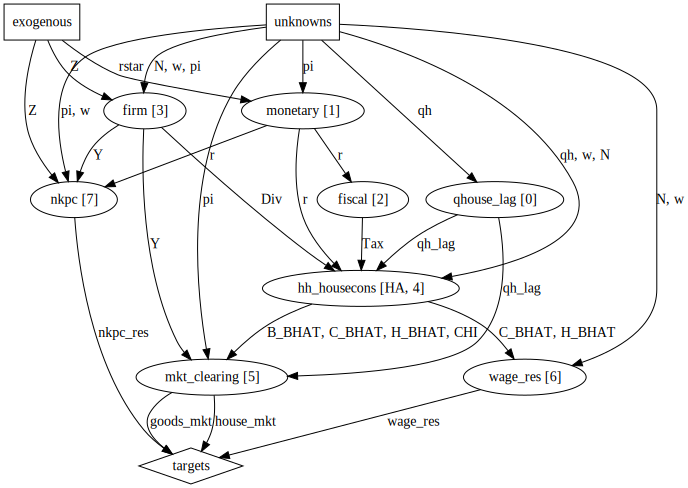

In [21]:
from sequence_jacobian import drawdag
inputs = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

drawdag(hank, inputs, unknowns, targets)

In [22]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'N', 'qh', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'nkpc_res', 'qh_lag'], inputs=['rstar', 'Z']>


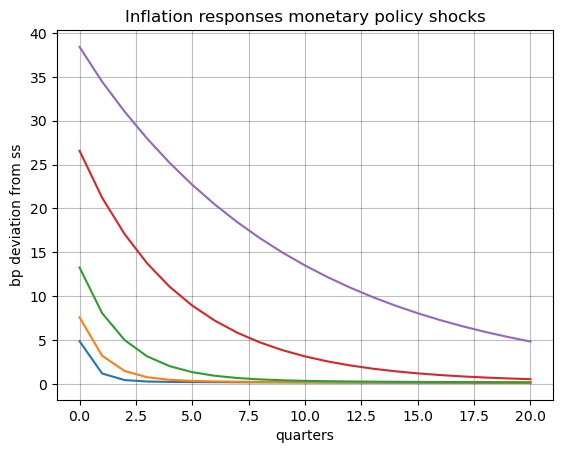

In [23]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar

plt.plot(10000 * dpi[:21])
plt.title(r'Inflation responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

# Appendix A. Debugging the policy functions

## A.1. Setting up the same calibration as for general equilibrium

In [ ]:
import warnings
warnings.simplefilter('always', RuntimeWarning)

b_bhat_grid, h_bhat_grid, k_grid, e_grid, Pi, b_grid = utils.make_grids(bmax, hmax, kmax, nB, nH, nK, nZ, rho_z, sigma_z, gamma, qh_lag)
z_grid = utils.income(e_grid, tax, w, N)

# use backward induction to solve for the steady state policy functions
Vh_p, Vb_p, h_bhat, b_bhat, c_bhat, _ = utils.policy_ss(Pi, h_bhat_grid, b_bhat_grid, z_grid, e_grid, k_grid, beta, 
                                         gamma, theta, sigma, qh, qh_lag, r, alpha, tol=1E-8, max_iter=5_000, debug = False)

c, h, b, b_endo = utils.bhat_to_b(h_bhat_grid, b_bhat_grid, b_grid, z_grid, c_bhat, h_bhat, gamma, alpha, r, qh, qh_lag)